# ME/EECS/BioE C106B/206B Homework 4


## Vision and Estimation
In this notebook, you'll find the coding section for homework 4, Vision and Estimation. To get started, **make a copy** of this notebook and save it in your drive.

If you haven't used a colab notebook environment before, notebooks are just like normal Python files! Each section of the code is split up into a small block called a code cell, which you can run by pressing shift+enter or the play button on the left side of each cell. Run the following code cell to import the libraries we'll be using in this assignment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# from google.colab.patches import cv2_imshow
# from cv2 import cv2_imshow

## Problem 1: Image Filtering and Feature Detection

#### Convolutions
In this question, we'll implement some basic techniques in image processing! We'll begin by implementing a 2D convolution sum, expressed by the formula:
$$
 F*I(x, y) = \sum_{i = -N}^N\sum_{j = -N}^N F(i, j)I(x - i, y - j)
$$
Where $F*I$ is called the convolution of $I$ with $F$. Convolution sums are used across image processing for things such as filtering and feature extraction! We can picture this operation as performing a weighted sum of the values of the image, $I$, in a small square window around some desired $(x, y)$ coordinates in the image. Since we might want to compute the convolution at an $(x, y)$ coordinate located at the edge of an image, if the term $I(x - i, y - j)$ ever goes out of bounds, we may set that term equal to zero in the sum. This is known as *zero padding*.

Let's implement the following function so we can apply convolutions to image processing:

In [3]:
def conv_sum(x, y, I, F):
  """
  Functionto implement a convolution sum at (x, y) coordinates in an image.
  Inputs:
    x (int): x coordinate (row index) in the image
    y (int): y coordinate (column index) in the image
    I (NumPy Array): black and white image matrix, contains ints from 0 to 255
    F (NumPy Array): convolution kernel matrix
  Returns:
    F*I (x, y) (float): convolution sum around a point (x, y)
  """
  #first, extract N for the conv sum. This is F.shape[0]//2 to get square of the correct dimn around (x, y)
  N = F.shape[0]//2

  """
  YOUR CODE HERE: Implement a convolution sum across a window from -N to N
  around x, y. Remember that range(a, b) includes a but doesn't include b!
  Hints:
  1. Consider using a double for loop for i and j in the convolution sum.
  2. Remember to deal with zero padding! When I[x - i, y - j] is out of range of
  the image shape, set that value to be equal to zero. You can use a try-except
  statement to do this easily.
  3. When calling elements of the convolution kernel, remember not to call negative
  indices! You should shift the indices you call by a constant if you use the convolution
  formula directly.
  """

  #perform the convolution sum
  convSum = 0 #initialize the sum value at 0

  #sum over the window here:
  for i in range(-N, N+1):
    for j in range(-N, N+1):
      #try-except block to handle out of range indices
      try:
        convSum += F[i + N, j + N]*I[x - i, y - j]
      except:
        convSum += 0

  #return the convolution sum
  return convSum

def conv_img(I, F):
  """
  Function to apply a convolution to an entire image I.
  Inputs:
    I (NumPy Array): black and white image matrix, contains ints from 0 to 255
    F (NumPy Array): convolution kernel matrix
  Returns:
    F*I (NumPy Array): array where each element is F*I(x, y)
  """
  convImg = I*0 #initialize array of zeros
  for x in range(I.shape[0]):
    for y in range(I.shape[1]):
      convImg[x, y] = conv_sum(x, y, I, F)
  #return the convolved image
  return convImg

#### Gaussian Smoothing
Run the cell below to generate a simple noisy image. We'll use this image to test out Gaussian smoothing, convolution, and several other techniques in image processing.

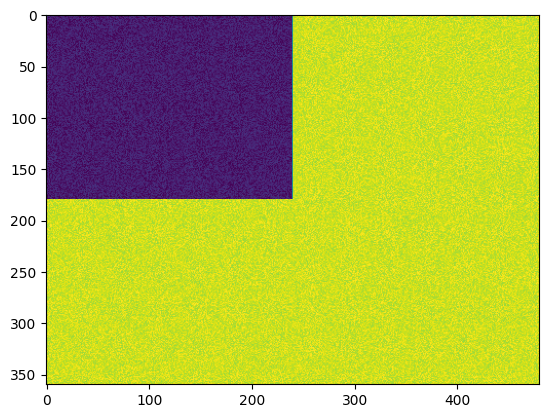

In [4]:
#first, create the noisy image - square within a white background (do not edit)
imgShape = (360, 480) #define image dimensions
noiseMag = 20 #define magnitude for the noise
squareSize = (imgShape[0]//2, imgShape[1]//2)
img = np.ones(imgShape)*(255 - noiseMag)
img[0:squareSize[0], 0:squareSize[1]] = noiseMag*np.ones((squareSize[0], squareSize[1]))
#add noise to the image
img = img + np.random.randint(-noiseMag, noiseMag, imgShape)

plt.imshow(img)
plt.show()

Now that we have our noisy image, let's try applying Gaussian smoothing. Recall that a $3\times 3$ convolution Kernel for a Gaussian smoothing operation is:
$$
F_{Gauss} =
\frac{1}{16}
\begin{bmatrix}
    1 & 2 & 1\\
    2 & 4 & 2\\
    1 & 2 & 1
\end{bmatrix}
$$
Note that this isn't the only possible Gaussian smoothing kernel! It can be further modified to have a different standard deviation and size.

Define the 3x3 Gaussian smoothing kernel from above as a NumPy Array and run the cell to observe the effects of Gaussian smoothing. Take a moment to compare the smoothed image to the original noisy image - can you see where the kernel blurs the image?

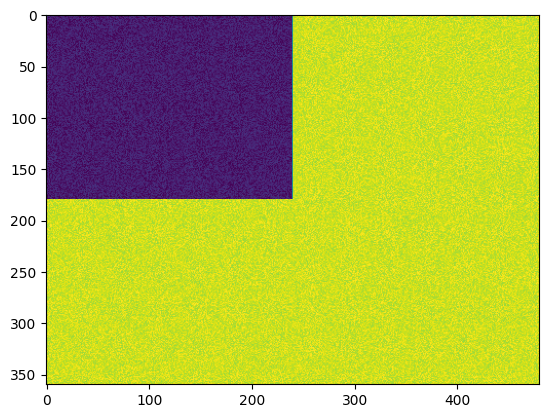

In [5]:
#define the Gaussian smoothing kernel using a 3x3 NumPy array
FGauss = 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]]) #YOUR CODE HERE: define the Gaussian Kernel using a NumPy array.

#call the image convolution on the noisy image from above
gaussImg = conv_img(img, FGauss)

#display the resulting image
plt.imshow(img)
plt.show()

#### Image Gradients
Now that we've smoothed our image and gotten rid of some of the noise, we may t taking the *gradients* of intensity in the vertical and horizontal directions of our image. Recall that we can use convolution kernels called *Sobel kernels* to approximate the gradients of image intensity. These kernels are defined:
$$
G_h =
        \begin{bmatrix}
            -1 & 0 & 1\\
            -2 & 0 & 2\\
            -1 & 0 & 1
        \end{bmatrix}, \;
        G_v =
        \begin{bmatrix}
            -1 & -2 & -1\\
            0 & 0 & 0\\
            1 & 2 & 1
        \end{bmatrix}
$$
Where $G_h$ and $G_v$ extract the horizonal and vertical gradients of the image, respectively. By taking the convolution of the image with each of these kernels, we can find the gradient of the image intensity in the horiontal and vertical directions!
$$
\nabla_h = G_h * I, \; \nabla_v = G_v * I
$$
If we compute these gradients at each point in the image, we may find the magnitude of the image intensity gradient at all points in the image by computing the Euclidean norm of the vertical and horizontal gradients:
$$
||\nabla_{img}|| = \sqrt{\nabla_h^2 + \nabla_v^2}
$$
Fill in the functions in the cell below to compute the magnitude of the image gradient at all points in the smoothed image.

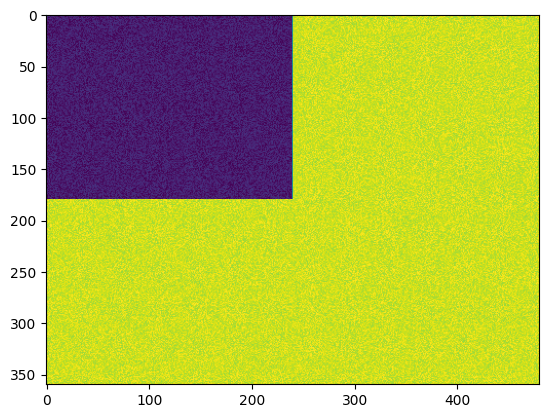

In [8]:
#first, define the two sobel kernels
Gh = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) #YOUR CODE HERE: define the horizontal Sobel kernel matrix using a NumPy array
Gv = np.array([[-1,-2,-1],[0,0,0],[1,2,1]]) #YOUR CODE HERE: define the vertical Sobel kernel matrix using a NumPy array

def img_grad(I):
  """
  Function to calculate the magnitude of the image gradient at all points.
  Inputs:
    I (NumPy Array): Image we want to take the gradient of
  Returns:
    ||Grad I|| (NumPy Array): NumPy array that contains the magnitude of the gradient at each point in I
    gradH (NumPy Array): horizontal gradient
    gradV (NumPy Array): vertical gradient
  """
  #first, take the horizontal and vertical gradients
  gradH = conv_img(I, Gh)
  gradV = conv_img(I, Gv)

  #find the magnitude of the gradient at all points
  magGrad = I*0 #intialize the matrix
  for i in range(I.shape[0]):
    for j in range(I.shape[1]):
      """
      YOUR CODE HERE: use the values of the horizontal and vertical gradient
      matrices, gradH and gradV (defined above), to find the magnitude of the
      gradient at each point in the image.
      """
      magGrad[i, j] = (gradH[i, j]**2 + gradV[i, j]**2)**0.5
  return magGrad, gradH, gradV

#apply this function to our Gaussian smoothed image
magGrad, gradH, gradV = img_grad(gaussImg)
plt.imshow(img)
plt.show()

As you should be able to see from your gradient magnitude calculation, we can extract the *edges* of features within the image by looking at the gradient of image intensity. Note that there might be a few extra edges that appear around the image borders due to zero padding - these can be removed without too much trouble.

Can we use this information about the location of edges to figure our where the *corners* of objects within the image are located?

Using the information we just calculated about the gradients of the image, we may apply an algorithm known as the *Harris Corner Detector* to verify if a pixel coordinate $(x, y)$ is at the corner of a feature within the image. The algorithm is defined:

#### Harris Corner Detector
1. Compute the image gradients $\nabla_h, \nabla_v$ in a small rectangular window $W$ around a point $(x, y)$ within the image.
2. Compute the following matrix by summing over all of the pixels within the window $W$ around the point $(x, y)$.
$$
G =
\begin{bmatrix}
\Sigma_W \nabla_h^2 & \Sigma_W \nabla_h \nabla_v\\
\Sigma_W \nabla_h \nabla_v & \Sigma_W \nabla_v^2
\end{bmatrix}
$$
Where $\Sigma_W$ refers to a sum performed over all pixels within the window $W$ around the point $(x, y)$
3. Define a cutoff threshold value $\tau$. If $\sigma_{min}(G)$, the smallest singular value of $G$, is *bigger* than the threshold $\tau$, then the point $(x, y)$ is at a corner!
4. Tune the value of $\tau$ until the corner features are correctly identified. Be aware that $\tau$ can be quite a large number!

Let's implement the Harris corner detector by filling in the following functions. Note that the first few functions have been implemented for you.

In [9]:
def get_window_grads(wX, wY, gradH, gradV):
  """
  Function to compute the gradients of interest within a window W.
  Inputs:
    wX (python list): x indices contained in a window around a point of interest
    wY (python list): y indices contained in a window around a point of interest
    gradH (NumPy Array): horizontal image gradient
    gradV (NumPy Array): vertical image gradient
  Returns:
    gradHList (Python List): a list containing the horizontal gradients at each point in the window
    gradVList (Python List): a list containing the vertical gradients at each point in the window
  """
  gradHList = []
  gradVList = []
  #now, get the horizontal and vertical gradient values at the necessary indices
  for x in wX:
    for y in wY:
      gradHList.append(gradH[x, y])
      gradVList.append(gradV[x, y])

  #return the two lists
  return gradHList, gradVList

def get_window_indices(x, y, N, imgShape):
  """
  Function to compute the indices of a square window of size N within an image I
  Inputs:
    x (int): x coordinate of window center
    y (int): y coordinate of window center
    N (int): side length of a square window (should be an odd numbered size)
    imgShape (tuple): (row, column) size of image
  Returns:
    wX (python list): x indices contained in a window around a point of interest
    wY (python list): y indices contained in a window around a point of interest
  """
  wX = []
  wY = []
  for i in range(-N//2, N//2 + 1):
    for j in range(-N//2, N//2 + 1):
      if (x + i) < imgShape[0] and (x + i) >= 0 and (y + j) < imgShape[1] and (y + j) >= 0:
        #only append if the coordinates fall within the image domain
        wX.append(x + i)
        wY.append(y + j)
  return wX, wY

def calc_g_matrix(x, y, gradH, gradV, wSize):
  """
  Function to calculate the G matrix for corner detection.
  Inputs:
    x (int): x image coordinate to check
    y (int): y image coordinate to check
    gradH (NumPy Array): horizontal image gradient matrix
    gradV (NumPy Array): vertical image gradient matrix
    wSize (int): size of the window to use in the calculation
  Returns:
    G (NumPy Array): G matrix used in edge detection algorithm
  """
  #first, get the window indices
  wX, wY = get_window_indices(x, y, wSize, gradH.shape)

  #next, find the lists of gradients within the image
  gradHList, gradVList = get_window_grads(wX, wY, gradH, gradV)

  #initialize the G matrix with all zeros
  G = np.zeros((2, 2))

  """
  YOUR CODE HERE: Compute the G matrix by using the sum over the window formula.
  Use the Python Lists of the H and V gradients to assist in your calculations.
  Hints:
  1. Perform the computation using a for loop. You can find the number of points
  in the window by checking the length of gradHList or gradVlist.
  2. To get the gradient values within the window, simply pick out the elements of
  gradHList and gradVList. gradHlist = [gradH0, gradH1, ...], gradVlist = [gradV0, gradV1, ...]
  where the elements in each list are ordered acording to window index.
  """

  #sum over the window of values
  G = np.zeros((2, 2))
  
  for i in range(len(gradHList)):
    G[0, 0] += gradHList[i]**2
    G[0, 1] += gradHList[i]*gradVList[i]
    G[1, 0] += gradHList[i]*gradVList[i]
    G[1, 1] += gradVList[i]**2

  #return the G matrix
  return G

def eval_corner(x, y, gradH, gradV, wSize, tau):
  """
  Function to check if the pixel loated at a point x, y is a corner.
  Inputs:
    x (int): x image coordinate to check
    y (int): y image coordinate to check
    gradH (NumPy Array): horizontal image gradient matrix
    gradV (NumPy Array): vertical image gradient matrix
    wSize (int): size of the window to use in the calculation
    tau (float): cutoff for minimum singular value of G
  Returns:
    G (NumPy Array): G matrix used in edge detection algorithm
  """
  #first, calculate the G matrix
  G = calc_g_matrix(x, y, gradH, gradV, wSize)

  """
  YOUR CODE HERE:
  Calculate the minimum singular value of the G matrix and check if it is
  larger than the threshold value, tau.
  Hints:
  1. To find the SVD of G, try using the function np.linalg.svd(). This will
  return the different components of the singular value decomposition of G,
  including all of the singular values of G.
  """

  #find the SVD of the G matrix

  #find the minimum singular value
  sigmaMin = np.min(np.linalg.svd(G)[1])

  #return its relation to the cutoff
  meetsCutoff = sigmaMin > tau

  return meetsCutoff

Let's test out our corner detector! Run the following cell to see how the Harris Corner Detector picks out the corner in our smoothed image. This code cell will draw a light grey area, which indicated the area it searches for a corner over, and then a bright white area within where it believes the corner is.

You should tune the value of tau such that the corner in the image is picked out clearly! If all works well, you should see that the corner of the black square gets highlighted. Note that tau will be quite a large value, possibly on the order of $10^5$ to $10^6$.

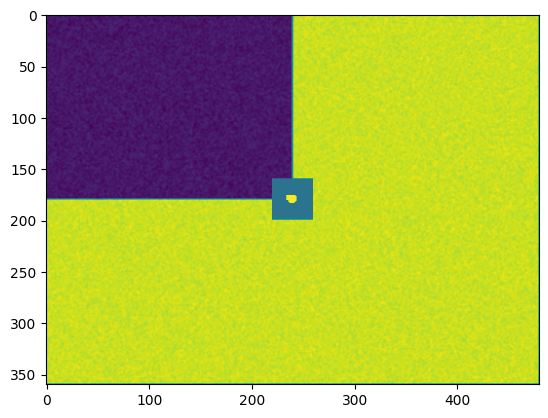

In [12]:
#define window size (do not change)
wSize = 5

#define cutoff for singular value - you may tune this value!
tau = 0.9*10**6 #YOUR CODE HERE: Tune the value of tau until the corner of the image is recognized!

#Search for corners over the window (do not change)
cornerX = []
cornerY = []
for x in range(160, 200):
  for y in range(220, 260):
    if eval_corner(x, y, gradH, gradV, wSize, tau):
      cornerX.append(x)
      cornerY.append(y)

#Draw the image with the corner overlaid
cornerImg = np.copy(gaussImg)
#draw a grey square over the area we search
for x in range(160, 200):
  for y in range(220, 260):
    cornerImg[x, y] = 100
for i in range(len(cornerX)):
  cornerImg[cornerX[i], cornerY[i]] = 255 #change pixel to white

plt.imshow(cornerImg)
plt.show()

## Problem 2: Feature Extraction with RANSAC
Let's work on programming a simple version of RANSAC to fit a line to $(x, y)$ data in a way that is *robust* to noise. Recall that the RANSAC algorithm may be applied as follows to fit a line to data in a way that is robust to outliers:


1.   Pick two random points from the set of points and plot a straight line between them.
2. Define an empty set called the inlier set.
3.   Find the distance from all other points in the set to the straight line. If the distance from a point to the line is less than a threshold $d$, add the point to the set of inlier points.
4. Repeat this process $k$ times. Pick the fit that results in the set with the largest number of inlier points.

Let's implement this algorithm in Python! Start by running the code cell below to generate a set of random, Gaussian distrbuted points, $S$. This will be our test data set for performing RANSAC.


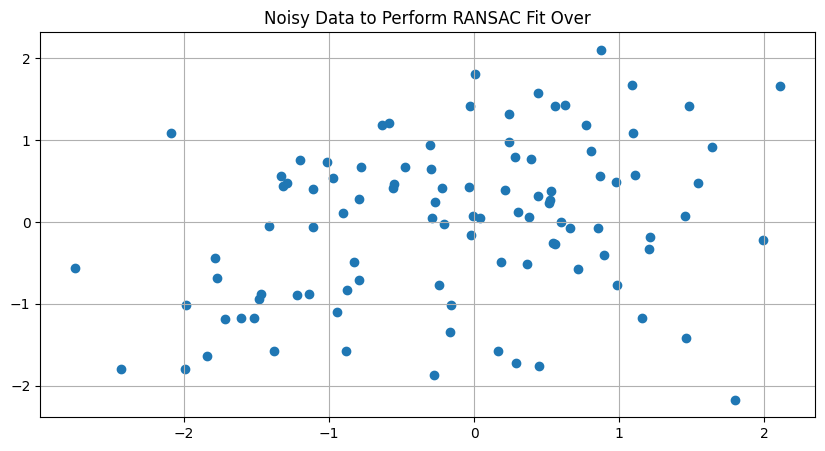

In [13]:
#generate a set of N random, gaussian distributed points
N = 100 #number of points
sigma = np.array([[1, 0.325], [0.325, 1]]) #covariance matrix
S = np.random.multivariate_normal([0, 0], sigma, (N, )).T #2xN set of data points

#Plot data to be fit
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(S[0, :].tolist(), S[1, :].tolist())
plt.title("Noisy Data to Perform RANSAC Fit Over")
plt.grid(visible=True)

In the following code cell, you'll implement three functions that perform the basic functionalities required for our RANSAC fit. calc_sq_distance() will calculate the distance from a point to the straight line fit, rand_fit() will peform a straight line fit between two randomly selected points in the data set, and ransac() will carry out the RANSAC algorithm.

In [14]:
#define RANSAC functions

def calc_sq_distance(S, m, x1, y1):
  """
  Function to calculate the squared distance from all of the points in a set S to a straight
  line of the form: y = m(x - x1) + y1
  Inputs:
    S (2xN NumPy Array): data set to perform fit over
    m (float): slope in linear fit
    x1 (float): x1 coordinate in linear fit
    y1 (float): y1 coordinate in linear fit
  Returns:
    distSqArr (NumPy array): Numpy Array of the distances from each point to the line (ordered by column in S)
  """
  #find the number of points
  N = S.shape[1]

  #define an empty distance squared array
  distSqArr = []

  for i in range(N):
    #extract the points px, py from the data matrix, S
    px, py = S[0, i], S[1, i]

    """
    YOUR CODE HERE: compute the minimum squared distance from (px, py) to the
    straight line, whose parameters are passed into this function.
    """
    dSq = ((py - m*(px - x1) - y1)**2)/(1 + m**2)

    #add the squared distance to the array.
    distSqArr.append(dSq)

  return np.array(distSqArr)

def rand_fit(S):
  """
  Function to perform a linear fit on a dataset by selecting two random points
  and drawing a straight line between them. This function should return:
    1. Slope of the linear fit: m = (x2 - x1)/(y2 - y1)
    2. The point x1 in the linear fit y = m(x - x1) + y1
    3. The point y1 in the linear fit y = m(x - x1) + y1

  Inputs:
    S (2xN NumPy Array): data set to perform fit over
  Returns:
    m, x1, y1 (float): slope, x and y coordinates of a point on the line
  """
  N = (S.shape)[1]
  #first, pick two random indices from the data set - the np.random.randint() function might be useful here!
  i1 = np.random.randint(0, N - 1)
  i2 = np.random.randint(0, N - 1)

  #modify the points s.t. they are not the same
  if i1 == i2:
    if i2 == N-1:
      i2 = i2 - 1
    else:
      i2 = i2 + 1

  #extract the points from the set S
  pt1 = S[:, i1].reshape((2, 1))
  pt2 = S[:, i2].reshape((2, 1))


  """
  YOUR CODE HERE:
  Find the values m, x1, y1 for the linear equation y = m(x - x1) + y1
  that passes through the randomly sampled points pt1, pt2, which have been
  extracted above for you. Note that pt1 and pt2 are (2x1) NumPy arrays that
  contain the x and y coordinates of each randomly sampled point.
  Notes:
  1. m, x1, y1 should all be floats, *not* NumPy arrays! Make sure you account
  for this in your calculations.
  """

  #perform the fit between the points - calculate the different fit parameters
  m = (pt2[1,0] - pt1[1,0])/(pt2[0,0] - pt1[0,0])
  x1 = pt1[0,0]
  y1 = pt1[1,0]

  #return the parameters
  return m, x1, y1

def ransac(S, k, dSq):
  """
  Function to perform a RANSAC fit on the data points.
  Inputs:
    S (2xN NumPy Array): data set to perform fit over
    k (int): number of times to perform random sampling in RANSAC algorithm
    dSq (float): threshold for squared distance to the fit
  Returns:
    mBest (float): slope from RANSAC fit
    x1Best (float): x1 from RANSAC fit
    y1Best (float): y1 from RANSAC fit
    numInliers (int): number of inliers for the best fit
  """
  #define a list of number of inliers
  numInlierArr = []

  #define a list of fit parameters - is a list of lists [m, x1, y1]
  fitParamArr = []

  for i in range(k):
    #perform a fit on the data set S
    m, x1, y1 = rand_fit(S)

    #find the squared distances from the points to the fit
    sqDistArr = calc_sq_distance(S, m, x1, y1)

    """
    YOUR CODE HERE:
    In this for loop, we perform a random fit and use the functions we implemented
    above to find the distance of each point in the data set to the fit.
    The distances from all of the points to the fit are stored in the Python list
    sqDistArr, which is defined above. Your job is to find numInliers, the number
    of points in this list which are at a distance below dSq to the line.
    Notes:
    1. The distance threshold dSq is passed in as an argument to this function.
    """

    #find the number of inliers - this is the line you need to implement.
    numInliers = np.sum(sqDistArr < dSq)

    numInlierArr.append(numInliers)
    fitParamArr.append([m, x1, y1])

  #find the index of the largest number of inliers
  bestIndex = np.argmax(np.array(numInlierArr))

  #find the number of inliers in the fit
  numInliers = numInlierArr[bestIndex]

  #extract the best parameters from that index
  mBest, x1Best, y1Best = fitParamArr[bestIndex]

  return mBest, x1Best, y1Best, numInliers


Let's test out our RANSAC fit by applying our functions to the dataset we generated earlier. Run the following code cell to visualize your RANSAC fit. You should tune the number of iterations, *k*, until there are at least 15 points in your inlier set.

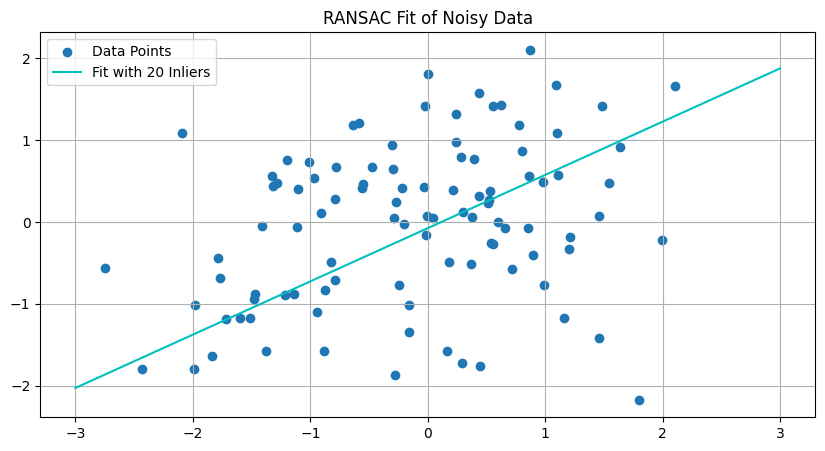

In [15]:
#define the distance squared threshold (do not change)
dSq = 0.1**2

##YOUR CODE HERE - Tune the number of iterations k of RANSAC to get the desired number of inliers
k = 100

#run the RANSAC function to get the fit and number of inliers
m, x1, y1, numInliers = ransac(S, k, dSq)

#generate points for the best fit
dataFit = lambda x: m*(x - x1) + y1
xPts = np.linspace(-3, 3)
yPts = [dataFit(x) for x in xPts]

#plot the resulting fit against the scatter
plt.scatter(S[0, :].tolist(), S[1, :].tolist())
plt.plot(xPts, yPts, 'c')
plt.legend(["Data Points", "Fit with {} Inliers".format(numInliers)])
plt.title("RANSAC Fit of Noisy Data")
plt.grid(visible=True)

## Problem 3: Least Squares State Estimation
In the problem of least squares estimation, we seek to find the best possible estimate of the value of a random variable $X \in \mathbb{R}^n$ given a measurement $Y = y \in \mathbb{R}^m$ that tells us something about the variable. For instance, we might seek to measure the position of our turtlebot given an AR tag and a camera sensor!

We can write the problem of estimating a state given a noisy measurement more formally through the following optimization problem:
$$
z^* = \underset{z \in \mathbb{R}^n}{\text{arg min }} \mathbb{E}[||X - z||^2 | Y = y ]
$$
If we can find a value $z^*$ that *minimizes* the expected value of the square of error, given that we've taken a measurement $Y = y$, we'll have found the least squares estimate for the value of the random vector $X$.

We can prove that the solution to this optimization problem is provided by the *conditional expectation* of $X$ given $Y = y$, denoted $\hat x_{|y}$:
$$
\hat x_{|y} = z^* = \mathbb{E}[X | Y = y]
$$
When $X, Y$ are Gaussian random vectors, this conditional expectation is something we can conveniently calculate using the formula:
$$
\hat x_{|y} = \mathbb{E}[X] + \Sigma_{xy}\Sigma_{yy}^{-1}(y - \mathbb{E}[Y])
$$
Where $\Sigma_{xy}, \Sigma_{yy}$ are the cross and auto covariances of the vectors $X, Y$. These are properties that may be found from the joint distribution of $X$ and $Y$.

Let's apply this formula for conditional expectation to optimally estimate the position of a turtlebot! Suppose we have a turtlebot which sits at a constant $x$ position. This position is repeatedly measured by a camera using an AR tag, a measurement that is subject to noise! Let's use least squares estimation to get a good idea of where our turtlebot is from these noisy measurements!

#### Conditional Estimation Function
Let's begin by implementing the formula for conditional estimation $\hat x_{|y}$ of Gaussian random vectors $X, Y$, which will give us the least squares estimate of $X$ given measurements and some probabilistic properties. Fill out the following function:

In [16]:
def cond_estimate(eX, eY, sigXY, sigYY, y):
  """
  Function to implement the conditional estimation formula.
  Inputs:
    eX ((Nx1) NumPy Array): expected value of the random vector X
    eY ((Mx1) NumPy Array): expected value of the random vector Y
    sigXY ((NxM) NumPy Array): cross covariance matrix of the X and Y vectors
    sigYY ((MxM) NumPy Array): auto covariance matrix of the Y vector
    y ((Mx1) NumPy Array): vector of measurements
  Returns:
    xHaty ((Nx1) NumPy Array): conditional expected value of X given measurement y
  """
  #YOUR CODE HERE: Implement the conditional estimation equation for Gaussian vectors
  return eX + sigXY @ np.linalg.inv(sigYY) @ (y - eY)

Now that we have our conditional estimation function, let's apply it to estimate the $x$ position of our turtlebot. In this case, $X$ will be a random variable representing the position of the turtlebot, while $Y$ will be a random vector representing the measurements we take of the turtlebot's position.

In the following code cell, we repeatedly sample the position of the turtlebot, and append each new measurement to $y$, a vector of measurements of the $x$ position of the turtlebot. Run the code cell to see the how the least squares estimator rejects measurement noise! Attach the plot generated by the code to your solution.

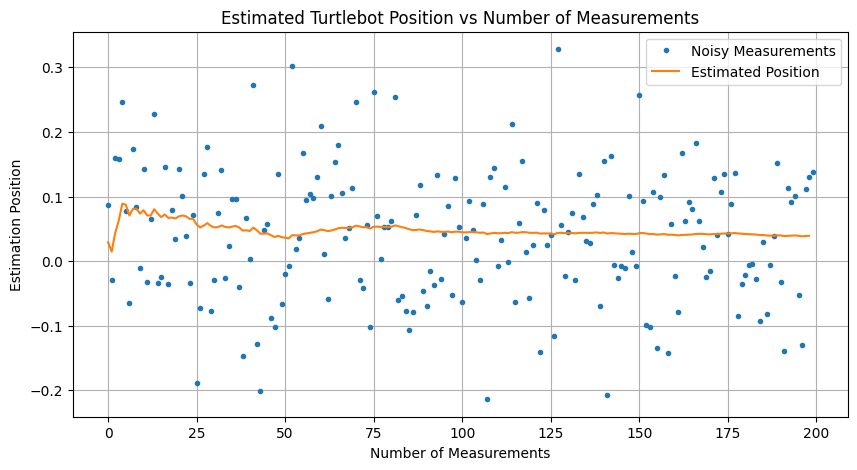

In [17]:
#initialize the noise properties - will update these as we go along. Assume that the turtlebot coords are uncorrelated.
sig = 0.01
corr = 0.005
ePos = 0
eX = np.array([[ePos]]).T
eY = np.array([[ePos]]).T

#define number of measurements to take
N = 200

#define the covariance over N measurements
sigYY =  0.5*sig+np.eye(N)*sig
sigXY = corr * np.ones((1, N))

#take N measurements of the system
y = np.random.multivariate_normal([ePos]*N, sigYY).reshape((N, 1))

#run a loop estimating the position of the vehicle given each measurement
xPosEst = []
for i in range(N-1):
  #get the measurement
  yMeasured = y[0:(i+1)]
  eYi = np.ones(((i+1), 1))*ePos

  #get the covariance
  sigYYi = sigYY[0:(i+1), 0:(i+1)]
  sigXYi = sigXY[:, 0:(i+1)]

  #apply a conditional estimate of the position
  xEst = cond_estimate(eX, eYi, sigXYi, sigYYi, yMeasured)

  #append the estimates to the array
  xPosEst.append(xEst[0, 0])

#plot the x results:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(y.reshape((N, )).tolist(), '.')
plt.plot(list(range(N-1)), xPosEst)
plt.xlabel("Number of Measurements")
plt.ylabel("Estimation Position")
plt.title("Estimated Turtlebot Position vs Number of Measurements")
plt.legend(["Noisy Measurements", "Estimated Position"])
plt.grid(visible = True)

Notice in the graph above how the least squares estimation helps us robustly predict the position of the robot from extremely noisy data!

## Problem 4: Kalman Filtering

In this question, we'll implement a Kalman filter for a simple noisy linear system! In robotics, a system known as the *double integrator* is an exceptionally useful test platform for developing controllers and filters.
Let's develop a Kalman filter to estimate the state of a simple double integrator system. In discrete time, the dynamics of the system may be described by the following:
$$
\begin{bmatrix}
x_1(k+1)\\
x_2(k+1)
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t\\
0 & 1
\end{bmatrix}
\begin{bmatrix}
x_1(k)\\
x_2(k)
\end{bmatrix}
+
\begin{bmatrix}
\frac{\Delta t^2}{2}\\
\Delta t
\end{bmatrix} u(k) + w(k)
$$
Where $\Delta t > 0$ is the sampling time of the discrete time system, $u(k)$ is the scalar input to the system at timestep $k$, and $w(k) \in \mathbb{R}^2$ is a vector of noise applied to the state equation of the system.\
The output equation of this system, which describes what we actually measure from our sensors, is:
$$
y =
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
x_1(k)\\
x_2(k)
\end{bmatrix} + v(k)
$$
Where $\mathbb{v}(k) \in \mathbb{R}$ is a random variable that expresses the noise experienced by the sensors.

Let's begin by filling in the different pieces of the system dynamics so we can represent the system as:
$$
x(k+1) = Ax(k) + Bu(k) + w(k)\\
y(k) = Cx(k) + v(k)
$$
Define the $A$, $B$, and $C$ matrices of the system as NumPy arrays in the code cell below using the provided value of $\Delta t$:

In [18]:
#Define the sampling time (Do not change)
deltaT = 0.01 #sampling time in seconds

"""
YOUR CODE HERE: Define the system A, B, C matrices. Note that the sampling time
delta t has been defined above for you.
"""

#define the A matrix of the system - should be a (2, 2) NumPy Array
A = np.array([[1, deltaT], [0, 1]])

#define the B matrix of the system - should be a (2, 1) NumPy Array (NOT (2, ))
B = np.array([[deltaT**2/2], [deltaT]]).T

#define the C matrix of the system - should be a (1, 2) NumPy Array (Not (2, ))
C = np.array([[1, 0]])

Now that we have the discrete system dynamics programmed, we can actually write out our Kalman filter functions to predict the state of the system! Recall that the following equations provide the different recursive terms of the Kalman filter:
$$
\mu_{k+1|k} = A\mu_{k|k} + B u_k\\
\Sigma_{k+1|k} = A \Sigma_{k|k}A^T + \Sigma_w\\
\mu_{k+1|k+1} =  \mu_{k+1|k} + \Sigma_{k+1|k}C^T(C\Sigma_{k+1|k}C^T + \Sigma_v)^{-1}(y_{k+1} - C \mu_{k+1|k})\\
\Sigma_{k+1|k+1} = \Sigma_{k+1|k} - \Sigma_{k+1|k}C^T(C\Sigma_{k+1|k}C^T + \Sigma_v)^{-1}C\Sigma_{k+1|k}
$$
Assuming the noise applied to the system is Gaussian and that the system is linear, we can compute $\mu_{k+1|k+1}$ to get an optimal estimate for the state vector $x(k+1)$ given our measurements.

Fill in the following functions to implement the different components of the Kalman filter:

In [19]:
"""
YOUR CODE HERE:
Implement the recursive Kalman filter equations in each of the functione below.
Use the matrices you defined in the code cell above and the recursive equations
above for reference.
"""

#define a function to find mu_(k+1 | k)
def mu_kp1_k(muKK, uK):
  """
  Function that returns the Kalman filter estimate of mu_(k+1 | k).
  This implements the first Kalman filter equation.
    Inputs:
      muKK (2x1 Numpy Array): mu_(k|k), the estimate at time k given measurements up to k
      uK (float): the input to the system at time k
    Returns:
      muKP1K (2x1 NumPy Array): mu_(k+1|k), the estimate of the k+1 state given measurements up to k
  """
  return A @ muKK + B*uK

#define a function to find Sigma_(k+1|k)
def sig_kp1_k(sigmaKK, sigmaW):
  """
  Function that returns the Kalman filter covariance, Sigma_(k+1 | k).
  This implements the second kalman filter equation.
  Inputs:
    sigmaKK (2x2 NumPy Array): sigma_(k|k), covariance of the state at time k given measurements up to k
    sigmaW (2x2 NumPy Array): covariance matrix of the noise applied to the state equation
  Returns:
    sigmaKP1K (2x2 NumPy Array): sigma_(k+1 | k), covariance of the next state given measurements up to k
  """
  return A @ sigmaKK @ A.T + sigmaW

#define a function to find mu(k+1|k+1)
def mu_kp1_kp1(muKK, uK, sigmaKK, sigmaW, sigmaV, yKP1):
  """
  Function that returns the Kalman filter estimate of mu_(k+1 | k+1).
  This implements the third Kalman filter equation.
    Inputs:
      muKK (2x1 Numpy Array): mu_(k|k), the estimate at time k given measurements up to k
      uK (float): the input to the system at time k
      sigmaKK (2x2 NumPy Array): sigma_(k|k), covariance of the state at time k given measurements up to k
      sigmaW (2x2 NumPy Array): covariance matrix of the noise applied to the state equation
      sigmaV (float): covariance of noise applied to output equation (measurement noise)
      yKP1 (1x1 NumPy Array):
    Returns:
      muKP1KP1 (2x1 NumPy Array): mu_(k+1|k+1), the estimate of the k+1 state given measurements up to k+1
  """
  #first, calculate muKP1K
  muKP1K = mu_kp1_k(muKK, uK)

  #next, calculate sigmaKP1K
  sigmaKP1K = sig_kp1_k(sigmaKK, sigmaW)

  #use these to calculate the estimate
  return muKP1K + sigmaKP1K @ C.T @ np.linalg.inv(C @ sigmaKP1K @ C.T + sigmaV) @ (yKP1 - C @ muKP1K)

#define a function to find Sigma(k+1|k+1)
def sig_kp1_kp1(sigmaKK, sigmaW, sigmaV):
  """
  Function that returns the Kalman filter covariance, Sigma_(k+1 | k).
  This implements the second kalman filter equation.
  Inputs:
    sigmaKK (2x2 NumPy Array): sigma_(k|k), covariance of the state at time k given measurements up to k
    sigmaW (2x2 NumPy Array): covariance matrix of the noise applied to the state equation
    sigmaV (float): covariance of noise applied to output equation (measurement noise)
  Returns:
    sigmaKP1KP1 (2x2 NumPy Array): sigma_(k+1 | k+1), covariance of the next state given measurements up to k+1
  """
  #first, calculate sigma_(K+1 | K)
  sigmaKP1K = sig_kp1_k(sigmaKK, sigmaW)

  #use this to calculate the covariance matrix sigma_(K+1 | K+1)
  return sigmaKP1K - sigmaKP1K @ C.T @ np.linalg.inv(C @ sigmaKP1K @ C.T + sigmaV) @ C @ sigmaKP1K

Now that we've implemented the recursive equation of the Kalman filter, we may use the filter to find the best estimate of the system's state at all times! Run the following code, which simulates the behavior of the system as it moves to a point, to see the efficacy of the Kalman filter. Attach the plots generated by the code to your solution.

In [20]:
#define the noise properties
eX0 = np.array([[1, 0]]).T #expected value of the initial state (start at 1m)
sigmaW = 0.001 #autocovariance for process noise
sigmaV = 0.25 #autocovariance for measurement noise
sigmaX0 = np.diag([sigmaW, sigmaW]) #covariance matrix of initial state.
eW = [0, 0] #expected value of process noise (zero)
eV = 0 #expected value of measurement noise

#define an input function
def get_input(xEst):
  """
  Returns an input as a function of the estimated state xEst
    Inputs:
      xEst (2x1 NumPy Array): estimate of the state vector
    Returns:
      u (float): input to the system
  """
  #LQR gains for state feedback
  K = np.array([[0.99137717, 1.72208683]])
  return -K@xEst

#define a next state function
def x_kp1(xK, uK):
  """
  Returns the state at time k+1 given the state and input at time k
  """
  #generate gaussian process noise wK - has same covariance as sigmaX0
  wK = np.random.multivariate_normal(eW, sigmaX0).reshape((2, 1))
  return A@xK + B*uK + wK

#define an output measurement function - gets a measurement at time k
def y_k(xK):
  """
  Returns a measurement of the state at time k
    Inputs:
      xK (2x1 NumPy Array): current state vector (ground truth)
    Returns:
      yK (1x1 NumPy Array): measurement of state vector at time K (stochastic)
  """
  #generate gaussian measurement noise
  vk = np.random.multivariate_normal([eV], np.eye(1)*sigmaV).reshape((1, 1))
  return C@xK + vk

#define simulation parameters
T = 5 #define a T second simulation (sampling time delta T is defined in the first code block)
xK = np.random.multivariate_normal([1, 0], sigmaX0).reshape((2, 1)) #Ground truth state vector - initialize randomly
yK = None #measurement of the state
muKK = np.zeros((2, 1)) #estimate of system state - initialize as zero
sigmaKK = np.eye((2)) #covariance - initialize as identity
uK = 0

#store a list of measurements, estimates, and ground truth
yMeasured = [] #measurements of x1
xEst = [] #estimate of the measured quantity from the kalman filter
xGT = [] #ground truth for the measured quantity


for i in range(int(T/deltaT)):
  #measure the current state of the system using the noisy sensor
  yK = y_k(xK)

  #call the Kalman filter update equations to get an estimate of the state - uses the previous input and estimate
  muKK = mu_kp1_kp1(muKK, uK, sigmaKK, sigmaW, sigmaV, yK) #estimate of state K given measurements up to K

  #call the Kalman filter update on covariance
  sigmaKK = sig_kp1_kp1(sigmaKK, sigmaW, sigmaV)

  #find the input to the system using the Kalman filter estimate
  uK = get_input(muKK)

  #store quantities in relevant arrays
  xGT.append(xK[0, 0])
  xEst.append(muKK[0, 0])
  yMeasured.append(yK[0, 0])

  #integrate the dynamics of the system - updates the deterministic state
  xK = x_kp1(xK, uK)


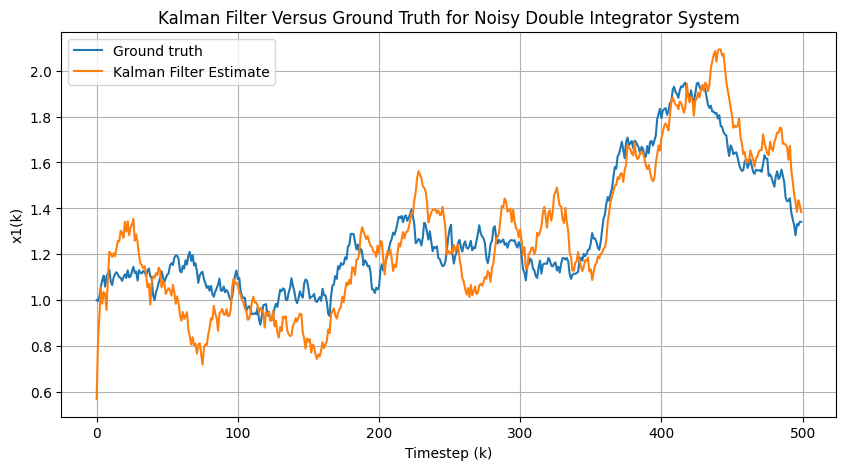

In [21]:
#plot the results
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(xGT)
plt.plot(xEst)
plt.title("Kalman Filter Versus Ground Truth for Noisy Double Integrator System")
plt.xlabel("Timestep (k)")
plt.ylabel("x1(k)")
plt.legend(["Ground truth", "Kalman Filter Estimate"])
plt.grid(visible=True)

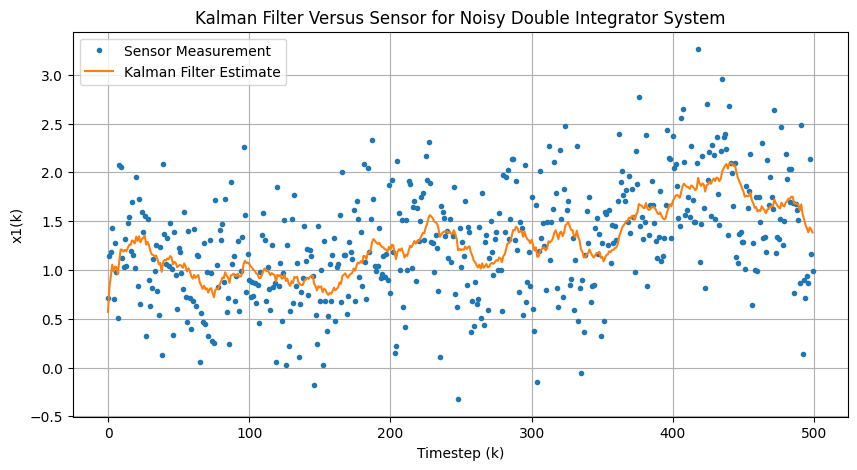

In [22]:
#plot the measurement versus the estimated stae
plt.plot(yMeasured, '.')
plt.plot(xEst)
plt.title("Kalman Filter Versus Sensor for Noisy Double Integrator System")
plt.xlabel("Timestep (k)")
plt.ylabel("x1(k)")
plt.legend(["Sensor Measurement", "Kalman Filter Estimate"])
plt.grid(visible=True)